In [14]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

sns.set(style="whitegrid")
np.random.seed(1337)
torch.manual_seed(1337)


In [15]:
def custom_make_moons(n_samples=500, noise=0.2, seed=1337):
    np.random.seed(seed)
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    outer_theta = np.linspace(0, np.pi, n_samples_out)
    outer_x = np.c_[np.cos(outer_theta), np.sin(outer_theta)]

    inner_theta = np.linspace(0, np.pi, n_samples_in)
    inner_x = np.c_[1 - np.cos(inner_theta), 1 - np.sin(inner_theta) - 0.5]

    X = np.vstack([outer_x, inner_x])
    y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])
    X += noise * np.random.randn(*X.shape)
    return X, y

X_train, y_train = custom_make_moons(500, noise=0.2)
X_test_02, y_test_02 = custom_make_moons(500, noise=0.2, seed=1338)
X_test_01, y_test_01 = custom_make_moons(500, noise=0.1, seed=1339)
X_test_03, y_test_03 = custom_make_moons(500, noise=0.3, seed=1340)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_01 = scaler.transform(X_test_01)
X_test_02 = scaler.transform(X_test_02)
X_test_03 = scaler.transform(X_test_03)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1337)



In [16]:
def plot_decision_boundary(model, X, y, title, is_torch=False):
    xx, yy = np.meshgrid(np.linspace(-2, 3, 200), np.linspace(-1.5, 2, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if is_torch:
        with torch.no_grad():
            Z = model(torch.tensor(grid, dtype=torch.float32)).numpy()
        Z = (Z > 0.5).astype(float)
    else:
        Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=15, edgecolor='k')
    plt.title(title)
    plt.tight_layout()



In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, l1_lambda=0.0, l2_lambda=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def l1_penalty(self):
        return sum(p.abs().sum() for p in self.parameters())

    def l2_penalty(self):
        return sum((p**2).sum() for p in self.parameters())


In [18]:
def train_model(model, X_train, y_train, X_val, y_val, patience=50, lr=0.01, epochs=1000):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = np.inf
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train)
        loss = F.binary_cross_entropy(out, y_train)
        loss += model.l1_lambda * model.l1_penalty() + model.l2_lambda * model.l2_penalty()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(X_val)
            val_loss = F.binary_cross_entropy(val_out, y_val)
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter > patience:
            break
    model.load_state_dict(best_state)
    return model


# Model 1: Plain MLP (early stopping)

In [19]:

mlp_es = MLP()
mlp_es = train_model(mlp_es, X_train, y_train, X_val, y_val)



# Model 2: MLP + L1 Regularization

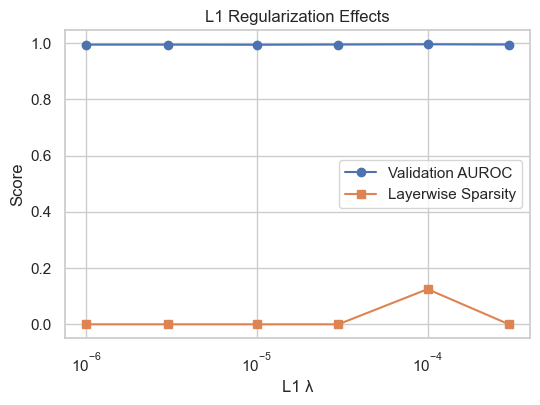

In [20]:

l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_auroc, sparsity = [], []
for lam in l1_grid:
    model = MLP(l1_lambda=lam)
    model = train_model(model, X_train, y_train, X_val, y_val)
    with torch.no_grad():
        val_pred = model(torch.tensor(X_val, dtype=torch.float32)).numpy()
    val_auroc.append(roc_auc_score(y_val, val_pred))
    weights = model.fc1.weight.detach().numpy()
    sparsity.append(np.mean(np.abs(weights) < 1e-3))

plt.figure(figsize=(6, 4))
plt.plot(l1_grid, val_auroc, 'o-', label='Validation AUROC')
plt.plot(l1_grid, sparsity, 's-', label='Layerwise Sparsity')
plt.xscale('log')
plt.xlabel('L1 λ')
plt.ylabel('Score')
plt.title('L1 Regularization Effects')
plt.legend()
plt.show()


#  L2 Regularization Grid Search for MLP

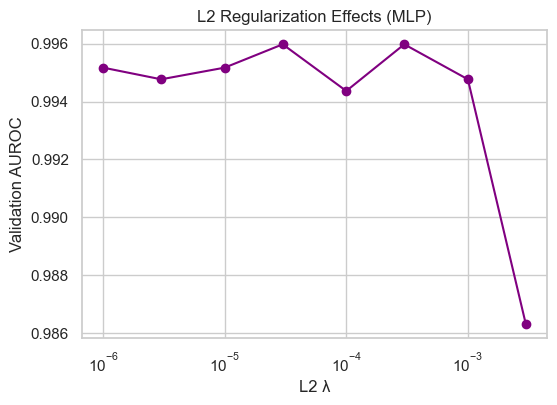

 Best L2 λ = 3.0e-05


In [21]:

l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]
val_auroc_l2 = []

for lam in l2_grid:
    model = MLP(l2_lambda=lam)
    model = train_model(model, X_train, y_train, X_val, y_val)
    with torch.no_grad():
        val_pred = model(torch.tensor(X_val, dtype=torch.float32)).numpy()
    val_auroc_l2.append(roc_auc_score(y_val, val_pred))

plt.figure(figsize=(6, 4))
plt.plot(l2_grid, val_auroc_l2, 'o-', color='purple')
plt.xscale('log')
plt.xlabel('L2 λ')
plt.ylabel('Validation AUROC')
plt.title('L2 Regularization Effects (MLP)')
plt.grid(True)
plt.show()

# Pick best λ for final model
best_l2_lambda = l2_grid[np.argmax(val_auroc_l2)]
print(f" Best L2 λ = {best_l2_lambda:.1e}")
mlp_l2 = MLP(l2_lambda=best_l2_lambda)
mlp_l2 = train_model(mlp_l2, X_train, y_train, X_val, y_val)



#  Logistic Regression Regularization Sweep


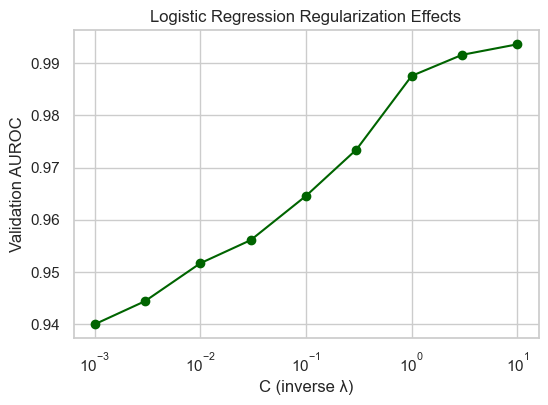

 Best Logistic Regression C = 10.000


,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [22]:

from sklearn.linear_model import LogisticRegression

c_values = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 0.3, 1, 3, 10]
val_auroc_lr = []
poly = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

for c in c_values:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(X_train_poly, y_train)
    val_pred = lr.predict_proba(X_val_poly)[:, 1]
    val_auroc_lr.append(roc_auc_score(y_val, val_pred))

plt.figure(figsize=(6, 4))
plt.plot(c_values, val_auroc_lr, 'o-', color='darkgreen')
plt.xscale('log')
plt.xlabel('C (inverse λ)')
plt.ylabel('Validation AUROC')
plt.title('Logistic Regression Regularization Effects')
plt.grid(True)
plt.show()

# Pick best C
best_c = c_values[np.argmax(val_auroc_lr)]
print(f" Best Logistic Regression C = {best_c:.3f}")

# Retrain best LR model
logreg = LogisticRegression(C=best_c, max_iter=1000)
logreg.fit(np.vstack([X_train_poly, X_val_poly]), np.hstack([y_train, y_val]))


In [23]:
def evaluate_model(model, X, y, is_torch=False, poly_transform=None):
    if poly_transform is not None:
        X = poly_transform.transform(X)
        pred = model.predict(X)
        prob = model.predict_proba(X)[:, 1]
    elif is_torch:
        with torch.no_grad():
            prob = model(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
        pred = (prob > 0.5).astype(int)
    else:
        pred = model.predict(X)
        prob = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, pred)
    auc = roc_auc_score(y, prob)
    return acc, auc



In [24]:
# Evaluate across noise levels
models = {
    "MLP (ES)": (mlp_es, True, None),
    "MLP (L1)": (MLP(l1_lambda=1e-4), True, None),
    "MLP (L2)": (mlp_l2, True, None),
    "LogReg (Poly)": (logreg, False, poly)
}
results = []
for name, (m, t, poly_t) in models.items():
    accs = []
    for (X, y) in [(X_test_01, y_test_01), (X_test_02, y_test_02), (X_test_03, y_test_03)]:
        acc, auc = evaluate_model(m, X, y, is_torch=t, poly_transform=poly_t)
        accs.append(acc)
    results.append([name, *accs, sum(p.numel() for p in m.parameters()) if t else len(logreg.coef_.ravel())])

df = pd.DataFrame(results, columns=["Model", "Acc with noise=0.1", "Acc wiht noise 0.2", "Acc with noise 0.3", "Params"])
df


,Model,Acc with noise=0.1,Acc wiht noise 0.2,Acc with noise 0.3,Params
0,MLP (ES),1.000,0.970,0.902,65
1,MLP (L1),0.852,0.834,0.816,65
2,MLP (L2),0.998,0.966,0.908,65
3,LogReg (Poly),0.994,0.960,0.910,9


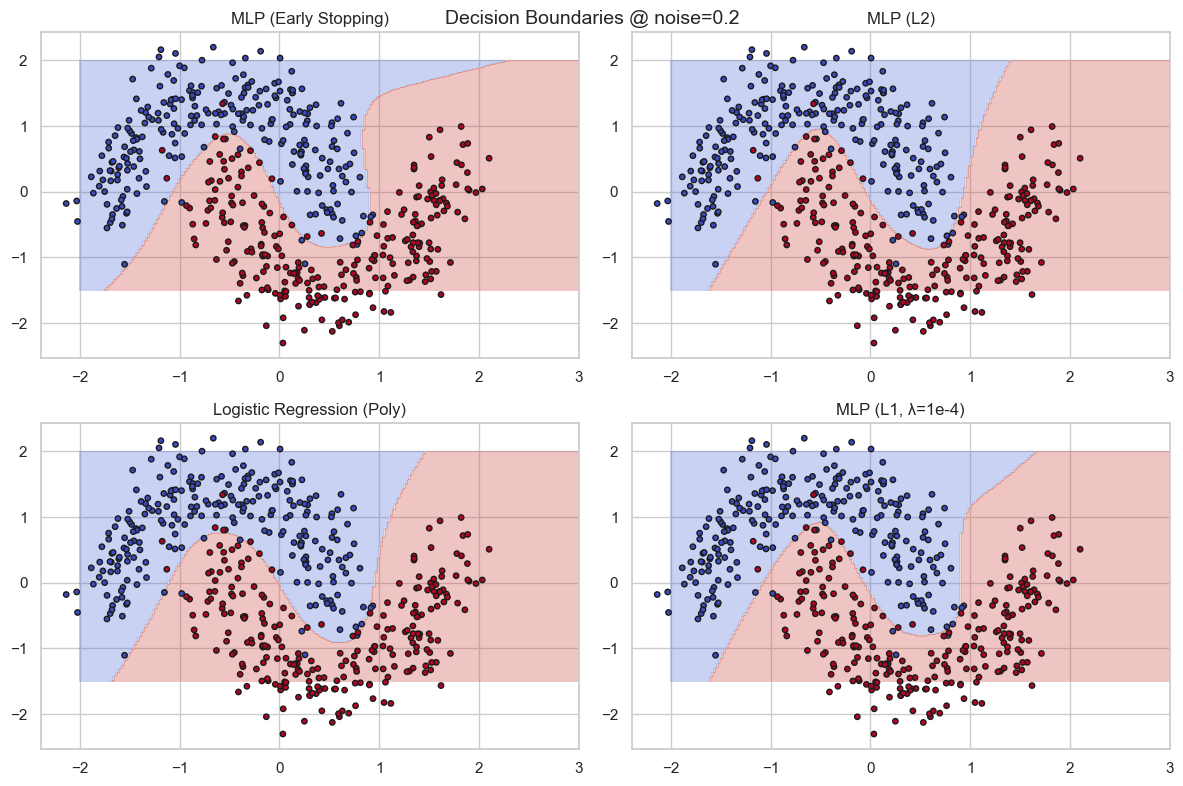

In [25]:

def plot_decision_boundary_poly(model, X, y, poly_transform, title):
    xx, yy = np.meshgrid(np.linspace(-2, 3, 200), np.linspace(-1.5, 2, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = poly_transform.transform(grid)
    Z = model.predict(grid_poly)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=15, edgecolor='k')
    plt.title(title)
    plt.tight_layout()


plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plot_decision_boundary(mlp_es, X_test_02, y_test_02, "MLP (Early Stopping)", is_torch=True)

plt.subplot(2, 2, 2)
plot_decision_boundary(mlp_l2, X_test_02, y_test_02, "MLP (L2)", is_torch=True)

plt.subplot(2, 2, 3)
plot_decision_boundary_poly(logreg, X_test_02, y_test_02, poly, "Logistic Regression (Poly)")

mlp_l1_best = MLP(l1_lambda=1e-4)
mlp_l1_best = train_model(mlp_l1_best, X_train, y_train, X_val, y_val)

plt.subplot(2, 2, 4)
plot_decision_boundary(mlp_l1_best, X_test_02, y_test_02, "MLP (L1, λ=1e-4)", is_torch=True)

plt.suptitle("Decision Boundaries @ noise=0.2", fontsize=14)
plt.show()


In [26]:
# Imbalance 70:30
mask = np.random.rand(len(y_train)) < 0.7
X_train_imb = X_train.copy()
y_train_imb = y_train.copy()
y_train_imb[~mask] = 1  # artificially imbalance

mlp_imb = MLP()
mlp_imb = train_model(mlp_imb, X_train_imb, y_train_imb, X_val, y_val)
acc, auc = evaluate_model(mlp_imb, X_test_02, y_test_02, is_torch=True)
print(f"Imbalanced Train: Test Acc: {acc:.3f}, AUROC: {auc:.3f}")




Imbalanced Train: Test Acc: 0.924, AUROC: 0.992


L1 regularization creates sparsity ,some weights go exactly to zero, which makes decision boundaries more jagged and piecewise.
L2 regularization smooths decision surfaces, better generalization to noisy data.
Class imbalance (70:30) biases model toward majority , accuracy may remain high but AUROC drops, which shows poor sensitivity.